In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import dlsim, butter, lfilter, welch
import scienceplots
import virtual_sensors as virtual
import pandas as pd

In [2]:
# print settings
np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

## Step excitation data from testbench

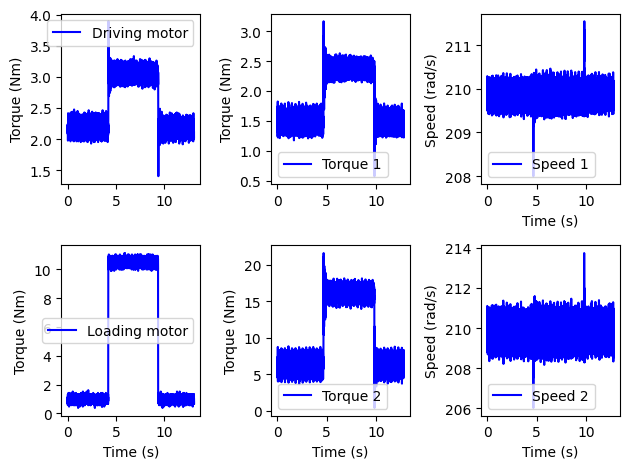

In [3]:
# Error correction
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# The motor dataset columns:
# | time | motor setpoint | motor | propeller setpoint | propeller |
motor_data_step = np.loadtxt("data/masters_data2/step_motor.csv", delimiter=",")

# The sensor dataset columns:
# | time | speed1 (encoder1) | speed2 (encoder2) | torque1 | torque2 |
sensor_data_step = np.loadtxt("data/masters_data2/step_sensor.csv", delimiter=",")

plt.subplot(231)
plt.plot(motor_data_step[:,0], motor_data_step[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_step[:,0], motor_data_step[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

(12867, 5)
0
1
2
3


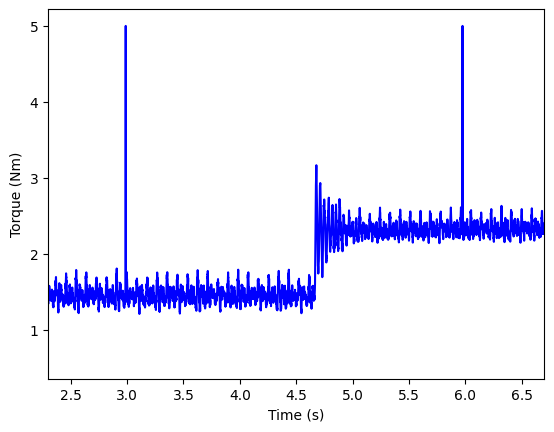

In [4]:
# add outliers to measurements
print(sensor_data_step.shape)
for i in range(int(sensor_data_step.shape[0] / 3000)):
    print(i)
    sensor_data_step[i*3000, 3] = 5
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], 'b-')
plt.xlim(2.3,6.7)
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.show()

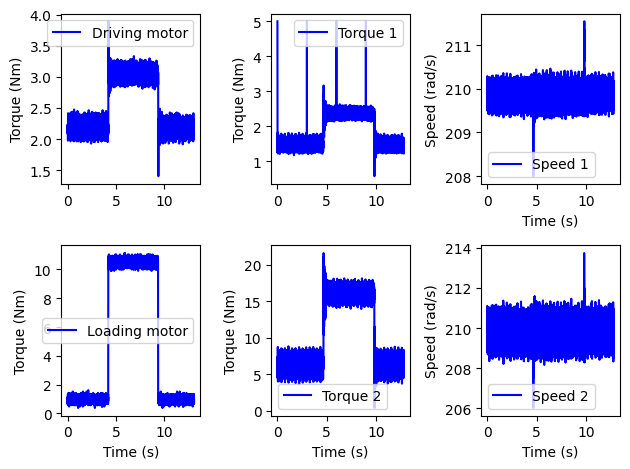

In [5]:
plt.subplot(231)
plt.plot(motor_data_step[:,0], motor_data_step[:,2], label='Driving motor', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(234)
plt.plot(motor_data_step[:,0], motor_data_step[:,4], label='Loading motor', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(232)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,3], label='Torque 1', color='blue')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(235)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,4], label='Torque 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.legend()

plt.subplot(233)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,1], label='Speed 1', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.subplot(236)
plt.plot(sensor_data_step[:,0], sensor_data_step[:,2], label='Speed 2', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.legend()

plt.tight_layout()
plt.show()

## Test-bench data as pandas dataframe

In [6]:
time = sensor_data_step[:,0]
measurements = sensor_data_step[:,1:] # measurement data from the encoder 1, encoder 2, torque transducer 1 and torque transducer 2
motors = np.vstack((motor_data_step[:,2], motor_data_step[:,4])).T # motor torque data

#create pandas dataframe
measurements_columns = ['Encoder 1','Encoder 2','Torque 1', 'Torque 2']
df = pd.DataFrame(data=measurements, columns=measurements_columns)
df['Time'] = time


## Construct State-Space Model

In [7]:
# get sampling time
dt = np.mean(np.diff(df['Time'].values))

inertias, stiffs, damps, damps_ext, ratios = virtual.new_parameters()
A, B, C, D = virtual.state_space_matrices(inertias, stiffs, damps, damps_ext, ratios, full_B=False, gear_B=False)
sys = virtual.ContinuousSystem(A,B,C,D)
sysd = virtual.c2d(sys,dt)


## Construct the Optimization Problem

In [8]:
# create a batch of data
batch_len = 200
time = np.array(df['Time'][:batch_len])
measurements = np.array([df['Encoder 1'][:batch_len], df['Encoder 2'][:batch_len], df['Torque 1'][:batch_len]])
data = virtual.DataClass(t=time[0:batch_len], y=measurements.reshape(-1,1))

# define parameters for optimization problem
pars = {
    'eps': 0.01,
    'lam': 0.01,
    'x0': np.zeros((sysd.n_states,1))
    }

#construct the virtual sensor
vs = virtual.Sensor(sysd, data, pars, method='svr')
print('problem created')

#solve the problem
vs.solve()

# retrieve results
uhat = vs.u.value
n,m = np.shape(uhat)
uhat = uhat.reshape(int(n/2),2)
zeta = vs.zeta.value
zeta_ast = vs.zeta.value


problem created
prob solved 


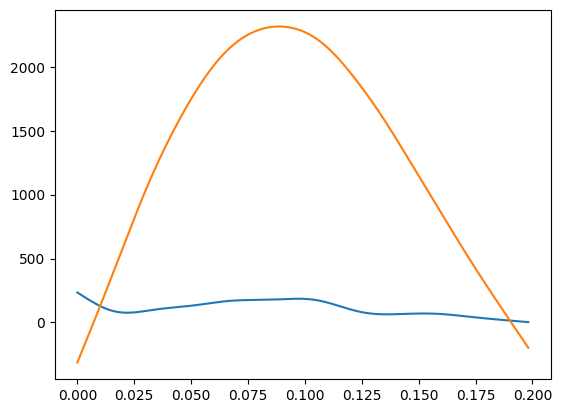

In [9]:
# plot results
plt.plot(time, uhat[:,0])
plt.plot(time, uhat[:,1])
plt.show()
